In [26]:
from keras.models import load_model
import tensorflow as tf
import numpy as np
from keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

In [2]:
vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet')

In [3]:
def loss_ssim(y_true, y_pred):
    # Calculer le data_range
    data_range = tf.reduce_max(y_true) - tf.reduce_min(y_true)
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=data_range))

In [35]:
layer_names = [layer.name for layer in vgg.layers if 'conv' in layer.name]
get_features_maps_a = tf.keras.Model(inputs = vgg.input, outputs = vgg.get_layer(layer_names[-8]).output)
get_features_maps_b = tf.keras.Model(inputs = vgg.input, outputs = vgg.get_layer(layer_names[-5]).output)
get_features_maps_c = tf.keras.Model(inputs = vgg.input, outputs = vgg.get_layer(layer_names[-2]).output)

In [6]:
""" AE_non_biased = load_model('Modeles/STIM/Autoencoder_mixte_64.hdf5', custom_objects={'loss_ssim': loss_ssim})
# 2°) On définit les features maps à utiliser comme appartnant aux trois dernières couches de convolution appartenant aux connexions séquentielles (i.e., non résiduelles)
# de l'AE non biaisé
layer_names = [layer.name for layer in AE_non_biased.layers if 'conv' in layer.name and not 'transpose' in layer.name] # pour récupérer dynamiquement
get_features_maps_a = tf.keras.Model(inputs = AE_non_biased.input, outputs = AE_non_biased.get_layer(layer_names[-5]).output)
get_features_maps_b = tf.keras.Model(inputs = AE_non_biased.input, outputs = AE_non_biased.get_layer(layer_names[-3]).output)
get_features_maps_c = tf.keras.Model(inputs = AE_non_biased.input, outputs = AE_non_biased.get_layer(layer_names[-2]).output) """

" AE_non_biased = load_model('Modeles/STIM/Autoencoder_mixte_64.hdf5', custom_objects={'loss_ssim': loss_ssim})\n# 2°) On définit les features maps à utiliser comme appartnant aux trois dernières couches de convolution appartenant aux connexions séquentielles (i.e., non résiduelles)\n# de l'AE non biaisé\nlayer_names = [layer.name for layer in AE_non_biased.layers if 'conv' in layer.name and not 'transpose' in layer.name] # pour récupérer dynamiquement\nget_features_maps_a = tf.keras.Model(inputs = AE_non_biased.input, outputs = AE_non_biased.get_layer(layer_names[-5]).output)\nget_features_maps_b = tf.keras.Model(inputs = AE_non_biased.input, outputs = AE_non_biased.get_layer(layer_names[-3]).output)\nget_features_maps_c = tf.keras.Model(inputs = AE_non_biased.input, outputs = AE_non_biased.get_layer(layer_names[-2]).output) "

In [36]:
def normalize(x):
    min_val = tf.reduce_min(x)
    max_val = tf.reduce_max(x)
    return (x - min_val) / (max_val - min_val)

def lpips(batch_pred, batch_true):
    # Convertir les images en 3 canaux si elles sont en niveaux de gris
    batch_pred = tf.image.grayscale_to_rgb(batch_pred)
    batch_true = tf.image.grayscale_to_rgb(batch_true)

    # Appliquer le prétraitement VGG16 aux images
    batch_pred = tf.keras.applications.vgg16.preprocess_input(batch_pred)
    batch_true = tf.keras.applications.vgg16.preprocess_input(batch_true)

    # Extraire les cartes de caractéristiques des deux images et les normaliser
    a_pred = normalize(get_features_maps_a(batch_pred))
    b_pred = normalize(get_features_maps_b(batch_pred))
    c_pred = normalize(get_features_maps_c(batch_pred))
    a_true = normalize(get_features_maps_a(batch_true))
    b_true = normalize(get_features_maps_b(batch_true))
    c_true = normalize(get_features_maps_c(batch_true))

    # Calculer les différences pondérées des caractéristiques
    # Pour l'exemple, nous utilisons des poids unitaires. Vous devez remplacer cela par les poids LPIPS réels
    w_a, w_b, w_c = 1, 1, 1

    diff_a = w_a * tf.reduce_mean(tf.square(a_pred - a_true))
    diff_b = w_b * tf.reduce_mean(tf.square(b_pred - b_true))
    diff_c = w_c * tf.reduce_mean(tf.square(c_pred - c_true))

    # Somme des pertes de chaque couche
    total_loss = diff_a + diff_b + diff_c

    return total_loss

In [38]:
def residual_block(x, filters, kernel_size=3, stride=1, activate=True):
    shortcut = x
    # Convolutions
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        # Ajuste les dimensions
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def residual_block_recon(x, filters, kernel_size=3, stride=1, activate=True):
    shortcut = x
    # Première convolution
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Deuxième convolution
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Ajuste les dimensions
    shortcut = tf.keras.layers.Conv2DTranspose(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def create_resnet_autoencoder(shape=(224, 224, 1), input_latent=64):
    input_img = tf.keras.Input(shape=shape)
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', use_bias=False)(input_img)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same')(x)

    # Encodeur
    x = residual_block(x, 64, 3, 2)
    x = residual_block(x, 128, 3, 2)
    x = residual_block(x, 250, 3, 2)
    x = residual_block(x, 512, 3, 2)
    x = residual_block(x, 250, 3, 1)
    x = tf.keras.layers.Flatten()(x)
    latent_space_layer = tf.keras.layers.Dense(input_latent, activation='relu', use_bias=False)(x)
    latent_space_layer_norm = tf.keras.layers.BatchNormalization(name='latent_space_layer_norm')(latent_space_layer)

    # Décodeur
    reshape_layer = tf.keras.layers.Reshape(target_shape=(1,1,input_latent))(latent_space_layer_norm)
    x_recon = residual_block_recon(reshape_layer, 256, 3, 2)
    x_recon = residual_block_recon(x_recon, 512, 3, 2)
    x_recon = residual_block_recon(x_recon, 256, 3, 2)
    x_recon = residual_block_recon(x_recon, 128, 3, 2)
    x_recon = residual_block_recon(x_recon, 64, 3, 2)
    x_recon = residual_block_recon(x_recon, 32, 3, 2)

    x_recon = tf.keras.layers.Conv2DTranspose(1, 1, activation='sigmoid', padding='same', use_bias=False)(x_recon)
    x_recon = tf.keras.layers.Resizing(224, 224)(x_recon)
    model = tf.keras.Model(inputs=input_img, outputs=[x_recon])
    lr1 = 0.01
    lr_schedule1 = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr1, decay_steps=10000,decay_rate=0.5,staircase=False)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule1, momentum = 0.9)
    model.compile(optimizer=optimizer, loss=lpips, metrics=['mae'])
    #model.summary()
    return model

In [39]:
def generator_to_array(generator):
    # Initialiser une liste pour stocker les échantillons
    num_samples = len(generator)
    samples = []
    # Itérer sur le générateur pour obtenir les échantillons
    for i in range(num_samples):
        batch = generator.next()
        for image in batch[0]:
            samples.append(image)  # Ajouter uniquement les données (ignorer les étiquettes)
    return np.array(samples)

def mean_cosinus_similarity(v1, v2):
    cosinus_similarity = 0
    nb_individus = v1.shape[0]
    for i in range(nb_individus):
        cosinus_similarity += np.dot(v1[i], v2[i]) / (np.linalg.norm(v1[i]) * np.linalg.norm(v2[i]))
    return cosinus_similarity/nb_individus

def calculate_mean_dispersion(latent_representations):
    centroid = np.mean(latent_representations, axis=0)
    distance_squared = np.sum((latent_representations - centroid)**2, axis = 1)
    return np.mean(distance_squared)

def comparaison_visages(asian, asian_predict, white, white_predict, ethnie):

    plt.figure(figsize=(15, 6))

    # Affichage des images du premier trainset
    plt.subplot(2, 5, (1, 5))
    plt.axis("off")
    plt.title('Caucasiens')
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(white[i], cmap='gray')
        plt.axis('off')
        plt.subplot(2, 5, i + 6)
        plt.imshow(white_predict[i], cmap='gray')
        plt.axis('off')

    # Titre global
    plt.suptitle(f'Comparaison des images d entrées et de sorties caucasiennes d espace latent {ethnie}')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 6))

    # Affichage des images du premier trainset
    plt.subplot(2, 5, (1, 5))
    plt.axis("off")
    plt.title('Asiatiques')
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(asian[i], cmap='gray')
        plt.axis('off')
        plt.subplot(2, 5, i + 6)
        plt.imshow(asian_predict[i], cmap='gray')
        plt.axis('off')

    # Titre global
    plt.suptitle('Comparaison des images d entrées et de sorties asiatiques')
    plt.tight_layout()
    plt.show()

def pca(latent_asian, latent_white, ethnie):
    pca = PCA(n_components=2)
    latent_pca_white = pca.fit_transform(latent_white)
    latent_pca_asian = pca.fit_transform(latent_asian)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_pca_white[:, 0], latent_pca_white[:, 1], color='r', alpha=0.5, label='white_predict')
    scatter_b = plt.scatter(latent_pca_asian[:, 0], latent_pca_asian[:, 1], color='b', alpha=0.5, label='asian_predict')
    plt.legend(handles=[scatter, scatter_b])
    plt.title(f'Projection ACP de l espace latent {ethnie}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

    return np.concatenate([latent_pca_white, latent_pca_asian], axis=0)


def cosinus_similarity(asian_flatten, asian_predict_flatten, white_flatten, white_predict_flatten):
    asian_cs = mean_cosinus_similarity(asian_flatten, asian_predict_flatten)
    white_cs = mean_cosinus_similarity(white_flatten, white_predict_flatten)
    print(f"Moyenne des similarités cosinus pour les individus caucasiens : {white_cs}")
    print(f"Moyenne des similarités cosinus pour les individus asiatiques : {asian_cs}")
    
def comparaison_dispersion(latent_asian, latent_white):
    asian_mean_dispersion = calculate_mean_dispersion(latent_asian)
    white_mean_dispersion = calculate_mean_dispersion(latent_white)
    print(f"Moyenne des dispersions des espaces latents pour les individus caucasiens : {white_mean_dispersion}")
    print(f"Moyenne des dispersions des espaces latents pour les individus asiatiques : {asian_mean_dispersion}")

def coef_bhattacharyya(latent_asian, latent_white):
    normalize_a = tf.nn.l2_normalize(np.mean(latent_asian, axis=0),axis=0)        
    normalize_b = tf.nn.l2_normalize(np.mean(latent_white, axis=0),axis=0)
    return tf.reduce_sum(tf.multiply(normalize_a,normalize_b))

def ssim_mean(ytrue, ypred, length):    
    res = 0
    for i in range(length):
        res+=ssim(ytrue[i], ypred[i], data_range=ytrue[i].max() - ytrue[i].min(), multichannel=False)
    
    return res/length

def structure_ssim(ytrue, ypred):
    return ssim(ytrue, ypred, data_range=ytrue.max() - ytrue.min(), multichannel=False)

In [40]:
train_datagen = ImageDataGenerator(rescale=1./255)
trainset_white = train_datagen.flow_from_directory(
    '../../Datasets/STIM_NB_LumNorm/Train',
    classes=['Caucasiens'],
    target_size=(224, 224), 
    batch_size=8, 
    class_mode='input',
    color_mode='grayscale')
testset_white = train_datagen.flow_from_directory(
    '../../Datasets/STIM_NB_LumNorm/Test',
    classes=['Caucasiens'],
    target_size=(224, 224), 
    batch_size=8, 
    class_mode='input',
    color_mode='grayscale')
trainset_asian = train_datagen.flow_from_directory(
    '../../Datasets/STIM_NB_LumNorm/Train',
    classes=['Asiatiques'],
    target_size=(224, 224),
    batch_size=8,
    class_mode='input',
    color_mode='grayscale')
testset_asian = train_datagen.flow_from_directory(
    '../../Datasets/STIM_NB_LumNorm/Test',
    classes=['Asiatiques'],
    target_size=(224, 224),
    batch_size=8,
    class_mode='input',
    color_mode='grayscale')
trainset_mixed = train_datagen.flow_from_directory(
    '../../Datasets/STIM_NB_LumNorm/Train',
    target_size=(224, 224), 
    batch_size=64, 
    class_mode='binary',
    color_mode='grayscale')
testset_mixed = train_datagen.flow_from_directory(
    '../../Datasets/STIM_NB_LumNorm/Test',
    target_size=(224, 224), 
    batch_size=64, 
    class_mode='binary',
    color_mode='grayscale')

Found 50 images belonging to 1 classes.
Found 6 images belonging to 1 classes.
Found 50 images belonging to 1 classes.
Found 6 images belonging to 1 classes.
Found 100 images belonging to 2 classes.
Found 12 images belonging to 2 classes.


In [41]:
# Fonction pour dupliquer le canal unique en trois canaux
"""def convert_to_three_channels(image):
    return tf.image.grayscale_to_rgb(image)

# Fonction pour pré-traiter les images pour VGG16
def preprocess_vgg16(image):
    image = tf.image.resize(image, (150, 150))
    image = tf.keras.applications.vgg16.preprocess_input(image)
    return image

# Fonction pour extraire les caractéristiques des couches intermédiaires
def extract_features(model, image):
    image = convert_to_three_channels(image)
    preprocessed_image = preprocess_vgg16(image)
    features = model(preprocessed_image)
    return features

# Calcul de la distance LPIPS
def lpips_loss(image1, image2):
    # Extraire les caractéristiques des deux images
    features1 = extract_features(vgg, image1)
    features2 = extract_features(vgg, image2)
    
    # Calculer la distance perceptuelle
    loss = tf.reduce_mean(tf.square(features1 - features2))
    return loss"""

'def convert_to_three_channels(image):\n    return tf.image.grayscale_to_rgb(image)\n\n# Fonction pour pré-traiter les images pour VGG16\ndef preprocess_vgg16(image):\n    image = tf.image.resize(image, (150, 150))\n    image = tf.keras.applications.vgg16.preprocess_input(image)\n    return image\n\n# Fonction pour extraire les caractéristiques des couches intermédiaires\ndef extract_features(model, image):\n    image = convert_to_three_channels(image)\n    preprocessed_image = preprocess_vgg16(image)\n    features = model(preprocessed_image)\n    return features\n\n# Calcul de la distance LPIPS\ndef lpips_loss(image1, image2):\n    # Extraire les caractéristiques des deux images\n    features1 = extract_features(vgg, image1)\n    features2 = extract_features(vgg, image2)\n    \n    # Calculer la distance perceptuelle\n    loss = tf.reduce_mean(tf.square(features1 - features2))\n    return loss'

In [42]:
model = create_resnet_autoencoder()

In [43]:
model.fit(x=trainset_white, epochs=300, validation_data=testset_white)

Epoch 1/300
7/7 [==============================] - 8s 443ms/step - loss: 2.8689e-05 - mae: 0.4104 - val_loss: 1.3019e-05 - val_mae: 0.3795
Epoch 2/300
7/7 [==============================] - 2s 285ms/step - loss: 2.8889e-05 - mae: 0.4108 - val_loss: 1.3011e-05 - val_mae: 0.3811
Epoch 3/300
7/7 [==============================] - 2s 287ms/step - loss: 2.8710e-05 - mae: 0.4103 - val_loss: 1.3003e-05 - val_mae: 0.3826
Epoch 4/300
7/7 [==============================] - 2s 286ms/step - loss: 2.8778e-05 - mae: 0.4110 - val_loss: 1.2996e-05 - val_mae: 0.3841
Epoch 5/300
7/7 [==============================] - 2s 318ms/step - loss: 2.8686e-05 - mae: 0.4104 - val_loss: 1.2989e-05 - val_mae: 0.3855
Epoch 6/300
7/7 [==============================] - 2s 287ms/step - loss: 2.8631e-05 - mae: 0.4110 - val_loss: 1.2981e-05 - val_mae: 0.3868
Epoch 7/300
7/7 [==============================] - 2s 288ms/step - loss: 2.8890e-05 - mae: 0.4103 - val_loss: 1.2969e-05 - val_mae: 0.3881
Epoch 8/300
7/7 [==========

KeyboardInterrupt: 

7/7 [==============================] - 0s 21ms/step


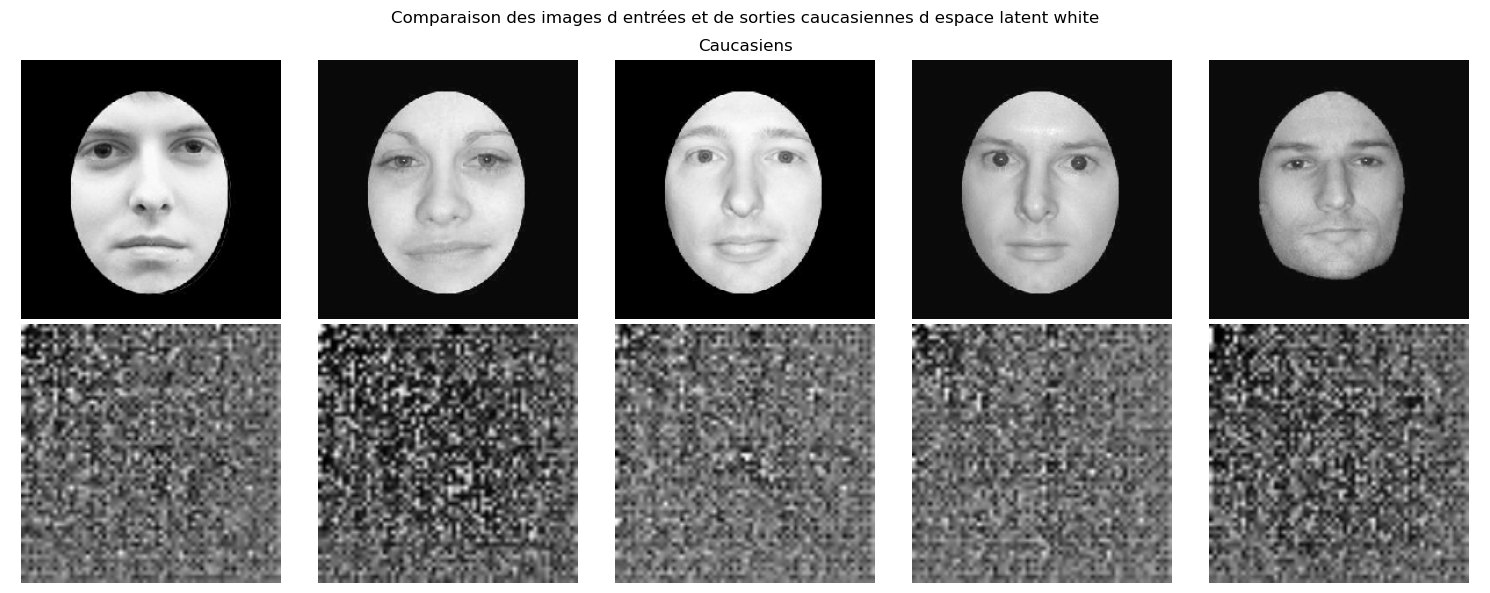

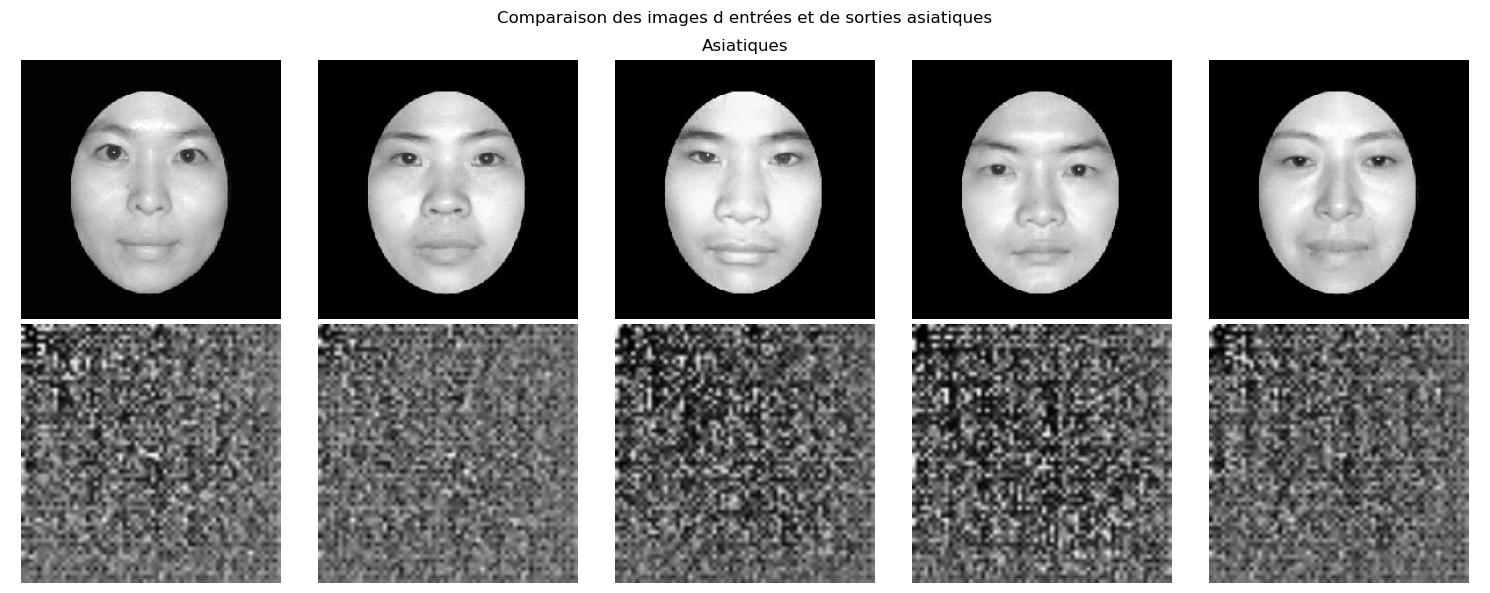

In [27]:
asian_predict = model.predict(trainset_asian).reshape(50, 224, 224)
white_predict = model.predict(trainset_white).reshape(50, 224, 224)
asian = generator_to_array(trainset_asian)
white = generator_to_array(trainset_white)
comparaison_visages(asian, asian_predict, white, white_predict, "white")

In [ ]:
model = create_resnet_autoencoder()
chekpoint_path = f'Modeles/STIM/Autoencoder_white1_64.hdf5'
checkpoint_callback = ModelCheckpoint(
    filepath=chekpoint_path,
    save_weights_only=False,
    save_frequency='epoch',
    save_best_only=True)
model.fit(x=trainset_white, epochs=50000, validation_data=testset_white, callbacks=[checkpoint_callback])
model = create_resnet_autoencoder()
chekpoint_path = f'Modeles/STIM/Autoencoder_asian1_64.hdf5'
checkpoint_callback = ModelCheckpoint(
    filepath=chekpoint_path,
    save_weights_only=False,
    save_frequency='epoch',
    save_best_only=True)
model.fit(x=trainset_white, epochs=50000, validation_data=testset_white, callbacks=[checkpoint_callback])

In [ ]:
test_asian = generator_to_array(testset_asian).reshape(6, 224, 224)
test_asian_predict = model.predict(testset_asian).reshape(6, 224, 224)
test_white = generator_to_array(testset_white).reshape(6, 224, 224)
test_white_predict = model.predict(testset_white).reshape(6, 224, 224)

In [ ]:
comparaison_visages(test_asian, test_asian_predict, test_white, test_white_predict, "white")

In [ ]:
asian_predict = model.predict(trainset_asian).reshape(50, 224, 224)
white_predict = model.predict(trainset_white).reshape(50, 224, 224)
asian = generator_to_array(trainset_asian).reshape(50, 224, 224)
white = generator_to_array(trainset_white).reshape(50, 224, 224)

In [ ]:
comparaison_visages(asian, asian_predict, white, white_predict, "asian")

In [ ]:
white = generator_to_array(trainset_white)
asian = generator_to_array(trainset_asian)

In [ ]:
lpips_loss(white, white).numpy()

In [ ]:
A = np.zeros((64,150,150,1))
B = np.ones((64,150,150,1))
lpips_loss(B, B).numpy()

In [ ]:
get_features_maps_a(asian).shape

In [ ]:
get_features_maps_a(white[0])

In [ ]:
# 3°) On entraîne les deux AE biaisé
# exemple avec un seul
AE_white = create_resnet_autoencoder(input_latent = 64)
AE_white.fit(trainset_asian, epochs = 500, verbose = 0)
# 4°) La MSE_{DNN} est la moyenne des MSE pour chaque bloc de features maps entre : l'entrée et sa reconstructioin par l'AE biaisé
# exemple sur une image de x_train asiatique
batch = next(trainset_asian)
entree_OOD = batch[0][0]
plt.imshow(tf.squeeze(entree_OOD), cmap='gray') # on utilise ici tf.squeeze pour retirer la dimension non nécessaire du canal de couleur
plt.show()
reconstruction_biased_batched = AE_white(batch[0])
reconstruction_biased = reconstruction_biased_batched[0]
plt.imshow(tf.squeeze(reconstruction_biased), cmap='gray') # idem
plt.show()

def mse(ytrue, ypred):
    return tf.reduce_mean(tf.square((ytrue-ypred)))
MSE_OOD_a = mse(ytrue = get_features_maps_a(entree_OOD), ypred = get_features_maps_a(reconstruction_biased))
MSE_OOD_b = mse(ytrue = get_features_maps_b(entree_OOD), ypred = get_features_maps_b(reconstruction_biased))
MSE_OOD_c = mse(ytrue = get_features_maps_c(entree_OOD), ypred = get_features_maps_c(reconstruction_biased))

MSE_DNN_OOD = (MSE_OOD_a + MSE_OOD_b + MSE_OOD_c) / 3
print(MSE_DNN_OOD.numpy()) #attention car la valeur max de 1 que l'on avait en comparaison matrice noire et matrice blanche ne tient plus ici,
# l'activation étant relu et donc définie sur R+ 

batch = next(datatest_white)
entree_IID = batch[0][0]
reconstruction_non_biased_batched = AE_white(batch[0])
reconstruction_non_biased = reconstruction_biased_batched[0]

plt.imshow(tf.squeeze(entree_IID), cmap='gray') # on utilise ici tf.squeeze pour retirer la dimension non nécessaire du canal de couleur
plt.show()
reconstruction_non_biased_batched = AE_white(batch[0])
reconstruction_non_biased = reconstruction_non_biased_batched[0]
plt.imshow(tf.squeeze(reconstruction_non_biased), cmap='gray') # idem
plt.show()

MSE_IID_a = mse(ytrue = get_features_maps_a(entree_IID), ypred = get_features_maps_a(reconstruction_non_biased))
MSE_IID_b = mse(ytrue = get_features_maps_b(entree_IID), ypred = get_features_maps_b(reconstruction_non_biased))
MSE_IID_c = mse(ytrue = get_features_maps_c(entree_IID), ypred = get_features_maps_c(reconstruction_non_biased))

MSE_DNN_IID = (MSE_IID_a + MSE_IID_b + MSE_IID_c) / 3
print(MSE_DNN_IID.numpy())

print(MSE_DNN_OOD.numpy() > MSE_DNN_IID.numpy()) #doit renvoyer majoritairement True si nos hypothèses tiennent